In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc, ticker
from mpl_toolkits.mplot3d import Axes3D
rc('animation', html='jshtml')
import scipy
from scipy import signal, linalg
import warnings
warnings.simplefilter("ignore")
from IPython.display import clear_output, HTML
import sys
sys.path.append("..")
sys.path.append("../shared")
sys.path.append("../IDL")
from wednesdaySPEED import simulation
import numba
from numba import njit, prange, jit
import entropy_estimators as ee
from copy import copy
import time
import numpy.matlib
from matplotlib.colors import LogNorm

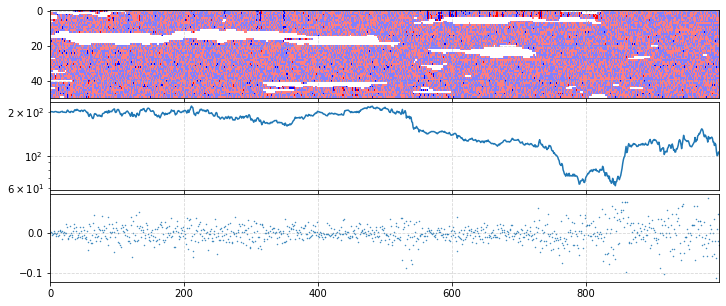

In [49]:
N0 = 1000
G,P,N,S,X,D,T,U,C, initial_account_balance = simulation(
    trigger = False, bound = False, pd = 0.025, pe = 0,
    ph = 0.03, pa = 0.7, N0=N0, N1=50, A=2, a=1, h=1, 
    pi1 = 0.5, pi2 = 0.2, pi3 = 0.3, ub=1000, lb=20)

fig, axs = plt.subplots(
        ncols=1, nrows=3, figsize=(12,5), sharex=True, gridspec_kw = 
        {'wspace':0, 'hspace':0.05}
    )
axs[0].imshow(G.T, aspect="auto", interpolation="None", cmap="bwr")
axs[1].set_yscale("log")
axs[1].plot(S)
axs[2].scatter(np.arange(X.shape[0]),X,s=0.2)
for ax in axs:
    ax.grid(linestyle="--", alpha=0.5)
plt.show()


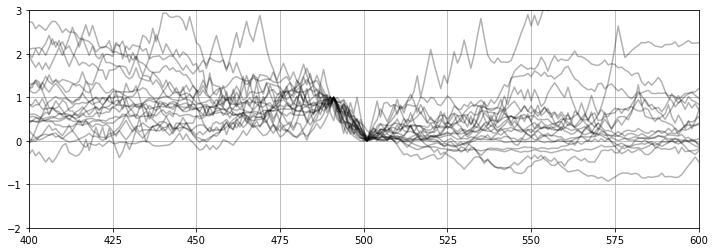

In [59]:
sims = 20
datacollapse = np.zeros((sims, N0))

for k in range(sims):
    N0 = 1000
    crash_window = 10
    G,P,N,S,X,D,T,U,C, initial_account_balance = simulation(
        trigger = False, bound = True, pd = 0.025, pe = 0,
        ph = 0.03, pa = 0.7, N0=N0, N1=50, A=8, a=1, h=1, 
        pi1 = 0.6, pi2 = 0.2
        , pi3 = 0.2, ub=1000, lb=20)

    dfx = pd.DataFrame(X+1)
    dfx_rollingprod = dfx.rolling(window=crash_window).agg(lambda x : x.prod()).fillna(1).to_numpy()
    dfx_rollingprod = dfx_rollingprod.reshape(dfx_rollingprod.shape[0])
    crash_index = dfx_rollingprod.argmin()
    # print(crash_index)
    minn = min(S[crash_index-crash_window:crash_index+crash_window])
    maxx = max(S[crash_index-crash_window:crash_index+crash_window])
    normalS = (S - minn) / (maxx - minn)
    movedS = np.pad(normalS, N0, constant_values=np.nan)
    movedS = np.roll(movedS, shift=(N0//2)-crash_index)
    movedS = movedS[N0:N0+N0]
    datacollapse[k] = movedS

plt.figure(figsize=(12,4))
plt.plot(datacollapse.T, color="k", alpha=0.3)
plt.xlim(400,600)
plt.ylim(-2,3)
plt.grid()
plt.show()

In [15]:
sims = 10
ND = 4
datacollapse = np.zeros((sims, N0))
movedDataArray = np.zeros((sims, ND, N0))

for k in range(sims):
    print(k, end="_")
    N0 = 1000
    crash_window = 10
    G,P,N,S,X,D,T,U,C, initial_account_balance = simulation(
        trigger = False, bound = True, pd = 0.025, pe = 0,
        ph = 0.03, pa = 0.7, N0=N0, N1=50, A=8, a=1, h=1, 
        pi1 = 0.6, pi2 = 0.2
        , pi3 = 0.2, ub=1000, lb=20)

    dfx = pd.DataFrame(X)
    dfx_rollingsum = dfx.rolling(window=crash_window).sum().fillna(0).to_numpy()
    dfx_rollingsum = dfx_rollingsum.reshape(dfx_rollingsum.shape[0])
    crash_index = dfx_rollingsum.argmin()
    minn = min(S[crash_index-crash_window:crash_index+crash_window])
    maxx = max(S[crash_index-crash_window:crash_index+crash_window])
    normalS = (S - minn) / (maxx - minn)
    movedS = np.pad(normalS, N0, constant_values=np.nan)
    movedS = np.roll(movedS, shift=(N0//2)-crash_index)
    movedS = movedS[N0:N0+N0]
    datacollapse[k] = movedS

    dfg = pd.DataFrame(G)
    dfgt = pd.DataFrame(G.T)
    window1 = 50
    window2 = 150
    original_length = G.shape[0]
    
    array_length = original_length - window2
    data = np.zeros(shape=(4, original_length))

    for i in range(original_length):
        if i < window2:
            continue
        C1 = dfg.iloc[i-window2:i].corr()
        C2 = dfgt.iloc[:, i-window2:i].corr()

        data[0,i] = C1.mean().mean()
        data[1,i] = C2.mean().mean()
        data[2,i] = linalg.eigvals(C1.fillna(0).to_numpy())[3]**4
        data[3,i] = linalg.eigvals(C2.fillna(0).to_numpy())[3]**4

    for i in range(ND):
        data[i] = (data[i] - min(data[i])) / (max(data[i]) - min(data[i]))
        data[i] = data[i] * 5 - 2

        movedData = np.pad(data[i], N0, constant_values=np.nan)
        movedData = np.roll(movedData, shift=(N0//2)-crash_index)
        movedData = movedData[N0:N0+N0]
        movedDataArray[k,i] = movedData

0_1_2_3_4_5_6_7_8_9_

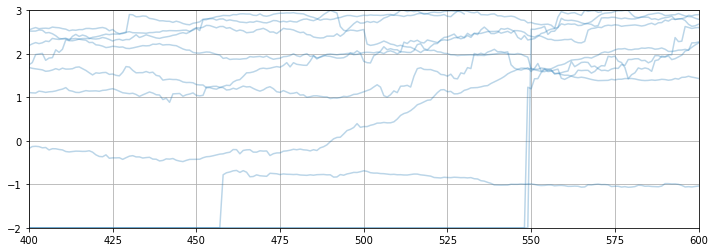

In [24]:
plt.figure(figsize=(12,4))
# plt.plot(datacollapse.T, color="k", alpha=0.3)
# for i in range(ND):
for i in [0]:
    plt.plot(movedDataArray[:,i,:].T, color=f"C{i}", alpha=0.3, label=f"{i}")
plt.xlim(400,600)
plt.ylim(-2,3)
plt.grid()
plt.show()

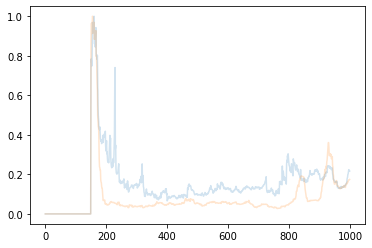

In [6]:
dfg = pd.DataFrame(G)
dfgt = pd.DataFrame(G.T)
window1 = 50
window2 = 150
original_length = G.shape[0]

ND = 4
array_length = original_length - window2
data = np.zeros(shape=(4, original_length))
for i in range(original_length):
    if i < window2:
        continue
    C1 = dfg.iloc[i-window2:i].corr()
    C2 = dfgt.iloc[:, i-window2:i].corr()

    # data[0,i] = C1.mean().mean()
    # data[1,i] = C2.mean().mean()
    data[2,i] = linalg.eigvals(C1.fillna(0).to_numpy())[3]**4
    data[3,i] = linalg.eigvals(C2.fillna(0).to_numpy())[3]**4

for i in range(ND):
    data[i] = (data[i] - min(data[i])) / (max(data[i]) - min(data[i]))
    
# ax.plot(data[0], label="Corr cell", alpha=0.2)
# ax.plot(data[1], label="Corr time", alpha=0.2)
plt.plot(data[2], label="Corr cell", alpha=0.2)
plt.plot(data[3], label="Corr time", alpha=0.2)

plt.show()

# ax2 = ax.twinx()
# ax2.plot(S, color="k")

In [7]:
# fig, axes = plt.subplots(nrows=1, figsize=(6, 4), constrained_layout=True)
# num_series = 1000
# num_points = 100
# x = np.linspace(0, num_points, num_series)
# # Generate unbiased Gaussian random walks
# Y = np.nan_to_num(datacollapse)
# num_fine = 1000
# x_fine = np.linspace(x.min(), x.max(), num_fine)
# y_fine = np.empty((num_series, num_fine), dtype=float)
# for i in range(num_points):
#     y_fine[i, :] = np.interp(x_fine, x, Y[i, :])
# y_fine = y_fine.flatten()
# x_fine = np.matlib.repmat(x_fine, num_series, 1).flatten()
# cmap = copy(plt.cm.plasma)
# h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[80, 120], range=[[44,55], [-1,2]])
# pcm = axes.pcolormesh(xedges, yedges, h.T, cmap=cmap)
# plt.show()

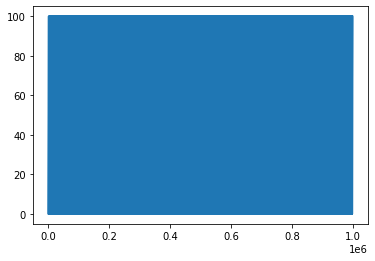

In [203]:
plt.plot(x_fine)